# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face recognition
Task is to recognize a faces

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import tensorflow
tensorflow.__version__

'2.1.0'

In [0]:
# importing necessary libraries
import os
import zipfile
import time
import datetime
import numpy as np
from random import randrange
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Model

#### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Change current working directory to project folder (2 mark)

In [0]:
os.chdir('/content/drive/My Drive/data/acv_project')

In [6]:
print("Current Working Directory", os.getcwd())

Current Working Directory /content/drive/My Drive/data/acv_project


### Extract the zip file (4 marks)
- Extract Aligned Face Dataset from Pinterest.zip

In [0]:
faces_dataset = os.path.join(os.getcwd(), "FaceDataset.zip")

In [0]:
archive = zipfile.ZipFile(faces_dataset, 'r')
archive.extractall()

### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 


In [0]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
        print("Generated metadata for the folder -- ", i)
    return np.array(metadata)

In [10]:
#Loading the images data into metadata
metadata = load_metadata("PINS")

Generated metadata for the folder --  pins_Aaron Paul
Generated metadata for the folder --  pins_alexandra daddario
Generated metadata for the folder --  pins_Alvaro Morte
Generated metadata for the folder --  pins_alycia debnam carey face
Generated metadata for the folder --  pins_Amanda Crew
Generated metadata for the folder --  pins_Amaury Nolasco
Generated metadata for the folder --  pins_amber heard face
Generated metadata for the folder --  pins_Anna Gunn
Generated metadata for the folder --  pins_anne hathaway
Generated metadata for the folder --  pins_barbara palvin face
Generated metadata for the folder --  pins_bellamy blake face
Generated metadata for the folder --  pins_Benedict Cumberbatch
Generated metadata for the folder --  pins_Betsy Brandt
Generated metadata for the folder --  pins_bill gates
Generated metadata for the folder --  pins_Brenton Thwaites
Generated metadata for the folder --  pins_brie larson
Generated metadata for the folder --  pins_Brit Marling
Generat

In [11]:
metadata.shape

(10770,)

In [12]:
# Checking data randomly
print(metadata[0])
print(metadata[randrange(metadata.shape[0])])
print(metadata[randrange(metadata.shape[0])])
print(metadata[randrange(metadata.shape[0])])
print(metadata[metadata.shape[0]-1])

PINS/pins_Aaron Paul/Aaron Paul0_262.jpg
PINS/pins_jeff bezos/jeff bezos81.jpg
PINS/pins_taylor swift/taylor swift12.jpg
PINS/pins_Melissa benoit/Melissa benoit17.jpg
PINS/pins_zendaya/zendaya99.jpg


### Define function to load image
- Define a function to load image from the metadata

In [0]:
# method to read the image from path
def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Load a sample image (4 marks)
- Load one image using the function "load_image"

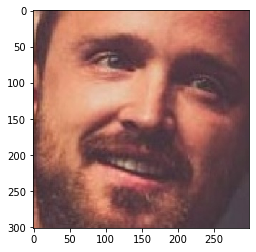

In [14]:
img = load_image(metadata[0].image_path())

plt.subplot()
plt.imshow(img)

### VGG Face model
- Here we are giving you the predefined model for VGG face

In [0]:
# creates tensorflow model
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model (4 marks)
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [0]:
model = vgg_face()
model.load_weights(os.path.join(os.getcwd(), "model", "vgg_face_weights.h5"), by_name=True)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

### Get vgg_face_descriptor

In [0]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [19]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generate embeddings for all images (10 marks)
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [20]:
embeddings = np.zeros((metadata.shape[0], 2622))
embeddings.shape

(10770, 2622)

In [0]:
def generate_img_embeddings():
  img_dsize = (224, 224)

  # loop through data in metadata
  for i in range(len(metadata)):
    img_path = os.path.join(os.getcwd(), metadata[i].image_path())

    try:
      img = load_image(img_path)
      img =  (img / 255.).astype(np.float32)     #scalling the data
      img = cv2.resize(img, dsize=img_dsize)

      embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
      embeddings[i] = embedding_vector

      if (i%100 == 0):
        print("Completed for {} images".format(i+1))
        
    except cv2.error as e:
      print("Unable to read the file: ", img_path)
    except:
      print("Exception: ", sys.exc_info()[0]," occured.")  

In [22]:
start_time = time.time()
generate_img_embeddings()
elapsed_time = time.time() - start_time

print("Total time: ", str(datetime.timedelta(seconds=elapsed_time)))

Completed for 1 images
Completed for 101 images
Completed for 201 images
Completed for 301 images
Completed for 401 images
Completed for 501 images
Completed for 601 images
Completed for 701 images
Completed for 801 images
Completed for 901 images
Completed for 1001 images
Completed for 1101 images
Completed for 1201 images
Completed for 1301 images
Completed for 1401 images
Completed for 1501 images
Completed for 1601 images
Completed for 1701 images
Completed for 1801 images
Completed for 1901 images
Completed for 2001 images
Completed for 2101 images
Completed for 2201 images
Completed for 2301 images
Completed for 2401 images
Completed for 2501 images
Completed for 2601 images
Completed for 2701 images
Completed for 2801 images
Completed for 2901 images
Completed for 3001 images
Completed for 3101 images
Completed for 3201 images
Completed for 3301 images
Completed for 3401 images
Completed for 3501 images
Completed for 3601 images
Completed for 3701 images
Completed for 3801 image

In [62]:
embeddings[0]

array([-2.47382181e-04, -2.69053708e-04,  8.35446699e-05, ...,
        6.48798814e-05, -3.94468661e-04,  1.01348569e-05])

In [63]:
embeddings[180]

array([-3.61709157e-04, -1.43629761e-04,  1.00556434e-04, ...,
        2.02624040e-04, -2.11219551e-04,  6.04850502e-05])

### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [0]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [65]:
distance(embeddings[2], embeddings[180])

5.406899316588386e-05

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

In [0]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle("Distance = {}".format( distance(embeddings[idx1], embeddings[idx2])))
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

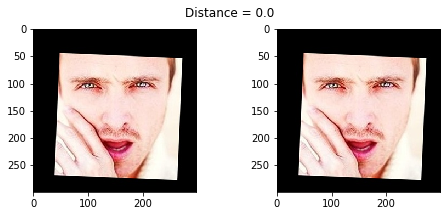

In [67]:
show_pair(2, 2)

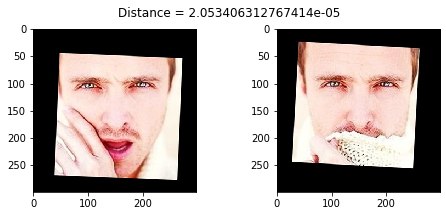

In [68]:
show_pair(2, 3)

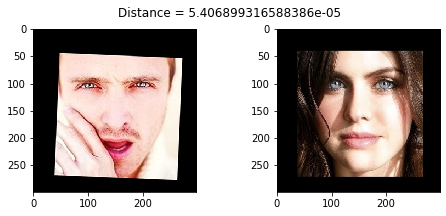

In [69]:
show_pair(2, 180)

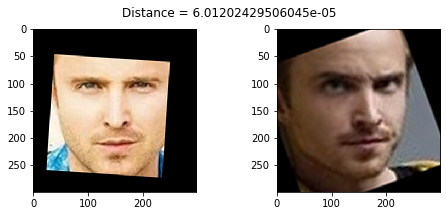

In [70]:
show_pair(30, 31)

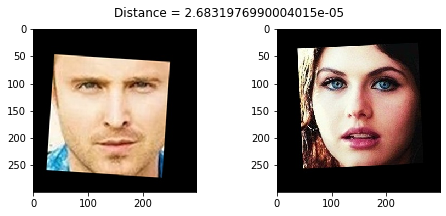

In [71]:
show_pair(30, 100)

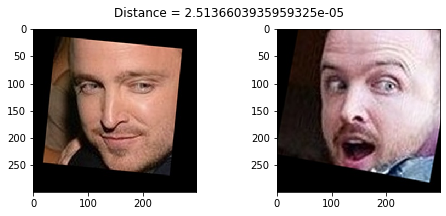

In [72]:
show_pair(70, 72)

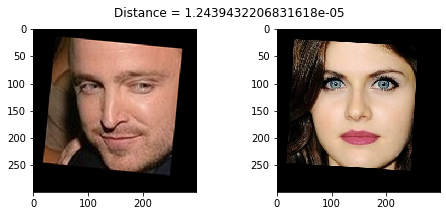

In [73]:
show_pair(70, 115)

### Create train and test sets (10 marks)
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [0]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

x_train = embeddings[train_idx]
x_test = embeddings[test_idx]

In [74]:
print("Training size: ", x_train.shape)
print("Testing size: ", x_test.shape)

Training size:  (9573, 2622)
Testing size:  (1197, 2622)


In [75]:
str(metadata[0])[5:].split('/')[0]

'pins_Aaron Paul'

In [0]:
# Getting the name of the person from metadata
name = []
for i in range(0, len(metadata)):
  name.append(str(metadata[i])[5:].split('/')[0])

In [0]:
y_labels = np.asarray(name)

In [78]:
y_labels.shape

(10770,)

In [79]:
y_labels[0]

'pins_Aaron Paul'

In [80]:
y_labels[180]

'pins_alexandra daddario'

In [81]:
y_labels[10769]

'pins_zendaya'

### Encode the Labels (6 marks)
- Encode the targets
- Use LabelEncoder

In [0]:
# Using LabelEncoder to encode the labels
encoder = LabelEncoder()
encoder.fit(y_labels)
y_encoded = encoder.transform(y_labels)

In [0]:
#Splitting the labels into train and test data
y_train = y_encoded[train_idx]
y_test = y_encoded[test_idx]

In [84]:
print("Training size: ", y_train.shape)
print("Testing size: ", y_test.shape)

Training size:  (9573,)
Testing size:  (1197,)


### Standardize the feature values (6 marks)
- Scale the features using StandardScaler

In [0]:
# Standarize features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

### Reduce dimensions using PCA (6 marks)
- Reduce feature dimensions using Principal Component Analysis

In [86]:
x_train_scaled.shape

(9573, 2622)

In [0]:
# Using PCA to reduce the features from '9573' to '1500'
pca = PCA(n_components = 1100)
p_x_train = pca.fit_transform(x_train_scaled)

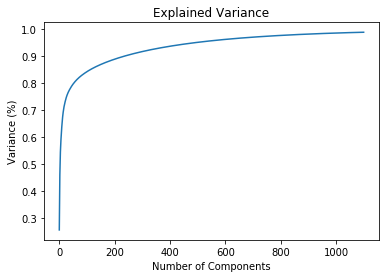

In [88]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()

In [89]:
p_x_train.shape

(9573, 1100)

In [90]:
p_x_test = pca.fit_transform(x_test_scaled)
p_x_test.shape

(1197, 1100)

### Build a Classifier (6 marks)
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [53]:
#SVM classifier
model_svm =SVC()
model_svm.fit(p_x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred = model_svm.predict(p_x_test)

In [92]:
acc_score = accuracy_score(y_test,y_pred)
print('score:',acc_score)

score: 0.045112781954887216


In [56]:
# Using SVM directly on scaled data 
model_svm_scaled =SVC()

start_time = time.time()
model_svm_scaled.fit(x_train_scaled, y_train)
elapsed_time = time.time() - start_time

print("Total time: ", str(datetime.timedelta(seconds=elapsed_time)))

Total time:  0:09:05.215548
Total time:  0:09:05.215548


In [0]:
y_pred = model_svm_scaled.predict(x_test_scaled)

In [95]:
acc_score = accuracy_score(y_test,y_pred)
print('score:',acc_score)

score: 0.19799498746867167


### Test results (2 mark)
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

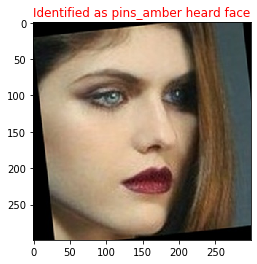

In [59]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = model_svm_scaled.predict(scaler.fit_transform([embeddings[test_idx][example_idx]]))
example_identity = encoder.inverse_transform(example_prediction)[0]
actual_label = y_labels[example_idx]

plt.imshow(example_image)
plt.title("Identified as {}".format(example_identity), color=("green" if example_identity==actual_label else "red"));

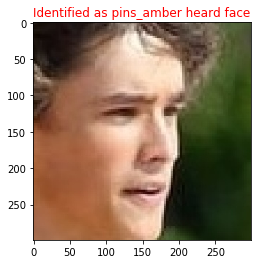

In [60]:
example_idx = 180

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = model_svm_scaled.predict(scaler.fit_transform([embeddings[test_idx][example_idx]]))
example_identity = encoder.inverse_transform(example_prediction)[0]
actual_label = y_labels[example_idx]

plt.imshow(example_image)
plt.title("Identified as {}".format(example_identity), color=("green" if example_identity==actual_label else "red"));